**Setting up the environment**


## PART 2: CNNs for color object recognition from CIFAR10 dataset



In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 104731227.60it/s]


Extracting DATA_CIFAR/cifar-10-python.tar.gz to DATA_CIFAR/
Files already downloaded and verified


In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 3, 32, 32])
torch.Size([64])


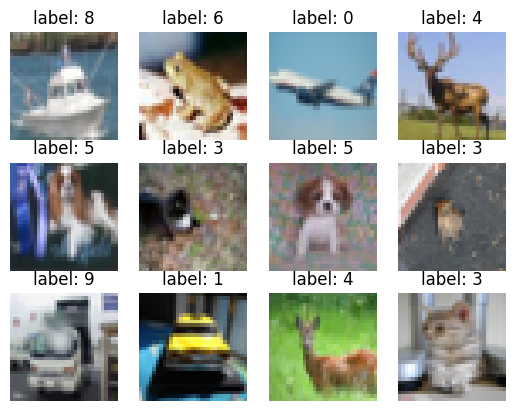

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [ ]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # Taille entrée 32*32*3
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        ) # taille des feature maps = 32*32*32
        self.pool = nn.MaxPool2d(2, 2) # taille = 16*16*32
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2) # taille = 16*16*64
        self.pool = nn.MaxPool2d(2,2) # taille = 8*8*64
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # Taille entrée 32*32*3 (cifar10)
            out_channels=128,
            kernel_size=7,
            stride=1,
            padding=3
        ) # taille des feature maps = 32*32*128
        self.pool = nn.MaxPool2d(2, 2) # taille = 16*16*128
        self.conv2 = nn.Conv2d(128,256, 5, 1, 2) # taille = 16*16*256
        self.pool = nn.MaxPool2d(2,2) # taille = 8*8*256
        self.fc1 = nn.Linear(8*8*256, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

2936970


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/20   Training loss: 2.0964   Validation loss: 1.8813   Train accuracy: 0.2716   Validation accuracy: 0.3377  
Epoch: 1/20   Training loss: 1.7899   Validation loss: 1.6881   Train accuracy: 0.3651   Validation accuracy: 0.3958  
Epoch: 2/20   Training loss: 1.6253   Validation loss: 1.5605   Train accuracy: 0.4223   Validation accuracy: 0.4460  
Epoch: 3/20   Training loss: 1.5131   Validation loss: 1.4773   Train accuracy: 0.4614   Validation accuracy: 0.4776  
Epoch: 4/20   Training loss: 1.4345   Validation loss: 1.4150   Train accuracy: 0.4873   Validation accuracy: 0.4983  
Epoch: 5/20   Training loss: 1.3792   Validation loss: 1.3527   Train accuracy: 0.5097   Validation accuracy: 0.5210  
Epoch: 6/20   Training loss: 1.3322   Validation loss: 1.3226   Train accuracy: 0.5269   Validation accuracy: 0.5299  
Epoch: 7/20   Training loss: 1.2928   Validation loss: 1.3893   Train accuracy: 0.5435   Validation accuracy: 0.5077  
Epoch: 8/20   Training loss: 1.2519   Validation

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

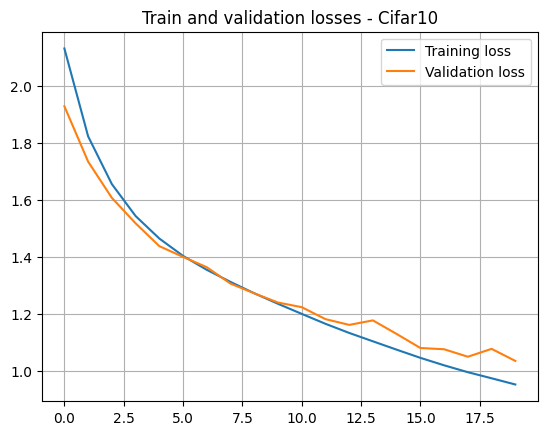

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

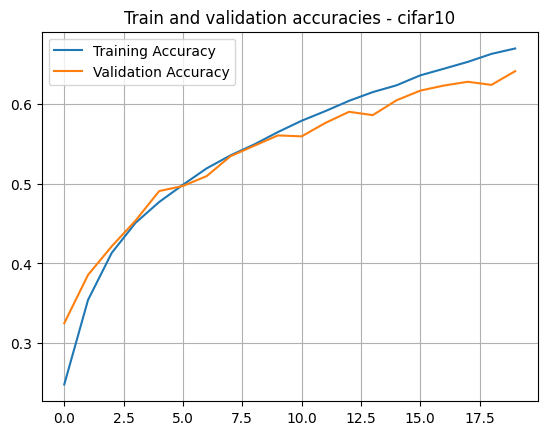

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

## tableau de resultat

**---------------Question 3---------------**

*  Your remarks and comments about the training process and the performance of CNN on Cifar10 ?
*  How could we improve the performance ?